In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def donchian_breakout(ohlc, lookback):
    
    upper = ohlc['close'].rolling(lookback - 1).max().shift(1)
    lower = ohlc['close'].rolling(lookback - 1).min().shift(1)
    
    signal = pd.Series(np.full(len(ohlc), np.nan), index=ohlc.index)
    
    signal.loc[ohlc['close'] > upper] = 1
    signal.loc[ohlc['close'] < lower] = -1
    signal = signal.ffill()
    
    return signal

def optimize_donchian(ohlc: pd.DataFrame):

    best_pf = 0
    best_lookback = -1
    r = np.log(ohlc['close']).diff().shift(-1)
    for lookback in range(10, 150):
        signal = donchian_breakout(ohlc, lookback)
        sig_rets = signal * r
        sig_pf = sig_rets[sig_rets > 0].sum() / sig_rets[sig_rets < 0].abs().sum()

        if sig_pf > best_pf:
            best_pf = sig_pf
            best_lookback = lookback

    return best_lookback, best_pf

In [3]:
def optimize_donchian(ohlc):

    best_pf = 0
    best_lookback = -1
    r = np.log(ohlc['close']).diff().shift(-1)
    for lookback in range(10, 150):
        signal = donchian_breakout(ohlc, lookback)
        sig_rets = signal * r
        sig_pf = sig_rets[sig_rets > 0].sum() / sig_rets[sig_rets < 0].abs().sum()

        if sig_pf > best_pf:
            best_pf = sig_pf
            best_lookback = lookback

    return best_lookback, best_pf

In [4]:
ohlcv = pd.read_csv("data/btc_usdt_2021_2025.csv")
lookback, pf = optimize_donchian(ohlcv)

In [5]:
print(f"Best lookback is {lookback}")

Best lookback is 91


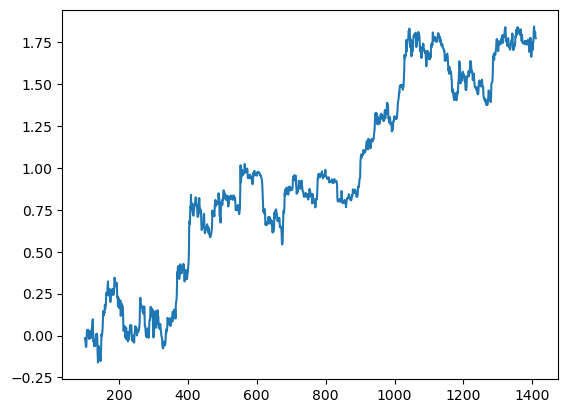

In [6]:
signal = donchian_breakout(ohlcv, lookback)

ohlcv['Return'] = np.log(ohlcv['close']).diff().shift(-1)
ohlcv['Donch_return'] = ohlcv['Return'] * signal

ohlcv['Donch_return'].cumsum().plot()
plt.show()

In [7]:
def walkforward_donch(ohlc: pd.DataFrame, train_lookback: int = 24 * 365 * 4, train_step: int = 24 * 30):

    n = len(ohlc)
    wf_signal = np.full(n, np.nan)
    tmp_signal = None
    
    next_train = train_lookback
    for i in range(next_train, n):
        if i == next_train:
            best_lookback, _ = optimize_donchian(ohlc.iloc[i-train_lookback:i])
            tmp_signal = donchian_breakout(ohlc, best_lookback)
            next_train += train_step
        
        wf_signal[i] = tmp_signal.iloc[i]
    
    return wf_signal